# A demonstration of the autonomous decision making system

### The intent of this notebook is to demonstrate the use of a decision making system for the Nova Rover. In order to do this we need to: 
1. Simulate the rover's motion and detections in a simulated environment.
2. Simulate detected obstacles and targets
3. Demonstrate decision making system that avoids 

In [12]:
import numpy as np
import math
import matplotlib.pyplot as plt

class rover:
    def __init__(self):
        # Initial conditions selected arbitrarily
        self.x = 0
        self.y = 0 
        self.theta = 0
        self.world = np.zeros((100,100))
    def moveToPosition(self,new_x,new_y):
        self.x = new_x
        self.y = new_y
    

Now that the class of the rover has been defined, we will implement an a* based pathfinding algorithm to search over the known grid. 
We begin by defining a grid that exists as the rovers main knowledge base. Called World ($W$)
Where, $W$ is a 2D array used to denote the "threat" or "opportunity" level of the grid square. All grid sqaures correspond to real world positions, each grid square has width $w$, which can be tuned for the application. 

Each cell has a value $W_{x,y} \in \mathbb{R}$ 

Lower values are an opportunity, Higher values are a threat. 
The algorithm for searching the space works as follows.
1. **Initialise** If the rover has just begun a new search for a target (could be a tennis ball) then initialise the array with the following. If this is not true skip this step. 
    1. Generate an array of zeros with height and width defined by the distance between the target and the rover as estimated by the rovers localization algorithm and the competition supplied gps coordinates. Ensure sufficient for overshoot. For example if it is $X$ m to the tennis ball and square width is defined as $w$ then $n = \frac{X}{w}$ is the height and width of the array. 
    2. Place a guassian function at the tennis ball gps location with amplitude $A = -1$ and each cell within range $3 \sigma$ from the centre calculate its value from that guassian. 
    


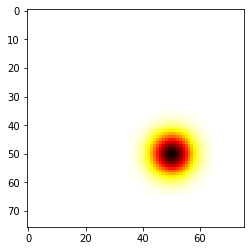

In [13]:
## Initialisation routine example in python. 

def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom
def applyGaussianToField(field,weight,x,y,sigma):
    for i in range(x-3*sigma,x+3*sigma):
        for j in range(y-3*sigma,y+3*sigma):            
            cart_distance = math.sqrt((x-i)**2 +(y-j)**2)
            if i in set(range(0,field.shape[0])) and j in set(range(0, field.shape[1])):
                field[i,j] = weight* normpdf(cart_distance,0,sigma) +field[i,j] 
    return field
def Initialise_tennis_ball_search():
    suspectedLocation = [50,50]
    roverLocation = [0,0]
    width = 1 # width of a grid cell = 0.1m (tuneable)
    sigma = 5 # standard deviation of the guassian
    fudgeFactor =1.5 ## Tuneable!
    x_size = int (fudgeFactor*(suspectedLocation[0]-roverLocation[0])+ 1)
    y_size = int (fudgeFactor*(suspectedLocation[1]-roverLocation[1])+ 1)
    RoverWorld = np.ones((x_size,y_size))
    
    RoverWorld = applyGaussianToField(RoverWorld,-20.0,suspectedLocation[0],suspectedLocation[1],5)
    return RoverWorld


arr = Initialise_tennis_ball_search()
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is what the rover will know about the world when it first starts up, it will identify the cell of highest interest (Lowest cell index value) and use a minimum cost pathfinding approach
2. **Remap** the rover will scan the environment with its sensors and re update the map using its current estimates. 
    1. Detect any obstacles and/or opportunities with a certain confidence level $p$ and with a certain confidence on the localisation $\sigma_ij$. 
    2. Update the _RoverWorld_ map with the targets and opportunities, scaling them appropriately based on cost. 
3. **Pathfind** Once the map has been updated, recompute the path forward using the new information. 
4. **Move** and iterate the process. 


In [14]:
# Defining obstacles notation x position y position size
obstacles = [(100,20,20,5),(100,20,40,5),(200,40,20,10)]


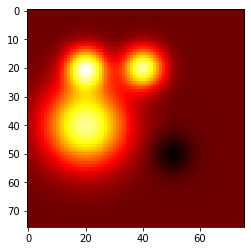

In [15]:
for obstacle in obstacles:
    arr = applyGaussianToField(arr,*obstacle)
    
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

This is an example of how the world will hopefully look from the perspective of the Rover while it is navigating. The remaining task is to pathfind over that graph. We will use the astar algorithm developed by MSP for the 2018 rover to accomplish this. See code below (however, the datails are not super relevant for our purposes here). 

Before anything else we need to select an objective of the rover, for simplicity we will use the minimum of the graph, something more complex (intelligent) could concievably be used though. 

In [16]:
from math import sqrt, inf
from itertools import product

def euclidean_heuristic_cost(curr, end):
    """
    Estimates cost from curr (x0,y0) to end (x1,y1) using Euclidean
    distance.
    """
    currx, curry = curr
    endx, endy = end
    return sqrt((currx-endx)**2 + (curry-endy)**2)

def reconstruct_path_to_destination(prev, end):
    """
    Constructs an in-order sequence of (x,y) coordinates (list of tuples)
    to the end destination using the mapping from nodes to their predecessors
    (prev).
    """
    path = [end]
    curr = end
    while curr in prev.keys():
        curr = prev[curr]
        path.insert(0, curr)
    return path

def get_successors(node, grid):
    """
    The neighbors of a cell (node) in the grid are the 8-surrounding cells.
    """
    successors = []

    nodex, nodey = node
    n_rows = len(grid)
    n_cols = len(grid[0])

    for dx, dy in product([-1,0,1],[-1,0,1]):
        # skip the current node itself
        if (dx == 0 and dy == 0):
            continue

        x = nodex + dx
        y = nodey + dy

        # skip successors that would take us off the edge of the grid
        if not (0 <= x < n_rows or 0 <= y < n_cols): continue

        cost = grid[x][y]

        successors.append( ((x, y), cost) )

    return successors

def node_with_min_fscore(open_set, f_cost): # open_set is a set (of cell) and f_cost is a dict (with cells as keys) 
    """
    Find the cell in open set with the smallest f score.
    """
    f_cost_open = dict([a for a in f_cost.items() if a[0] in open_set])
    return min(f_cost_open, key=f_cost_open.get)

def a_star(grid, start, end, heuristic_cost=euclidean_heuristic_cost):
    """
    Implementation of A Star over a 2D grid. Returns a list of waypoints
    as a list of (x,y) tuples.

    Input:
    : grid, 2D matrix
    : start, (x,y) tuple, start position
    : end, (x,y) tuple, end destination

    Output:
    : waypoints, list of (x,y) tuples
    """
    # the set of cells already evaluated
    closed_set = set()

    # the set of cells already discovered
    open_set = set()
    open_set.add(start)

    # for each cell, mapping to its least-cost incoming cell
    prev = {}
   
    # for each node, cost of reaching it from start (g_cost) 
    # for each node, cost of getting from start to dest via that node (f_cost)
    #   note: cell->dest component of f_cost will be estimated using a heuristic
    g_cost = {}
    f_cost = {}
    for r in range(len(grid)):
        for c in range(len(grid[0])):
            cell = (r, c)
            g_cost[cell] = inf
            f_cost[cell] = inf
    g_cost[start] = 0
    f_cost[start] = heuristic_cost(start, end)

    while open_set:
        # node in open set with min fscore
        curr = node_with_min_fscore(open_set, f_cost)
        
        # if we've reached the destination
        if curr == end:
            return reconstruct_path_to_destination(prev, curr)

        open_set.remove(curr)
        closed_set.add(curr)
        
        for neighbor, cost in get_successors(curr, grid):
            # ignore neighbors which have already been evaluated
            if neighbor in closed_set:
                continue

            curr_g_score =  g_cost[curr] + cost
            # add neighbor to newly discovered nodes
            if neighbor not in open_set:
                open_set.add(neighbor)

            # if we've already got a lower g_score for neighbor, then move on
            elif curr_g_score >= g_cost[neighbor]:
                continue

            prev[neighbor] = curr
            g_cost[neighbor] = curr_g_score
            f_cost[neighbor] = g_cost[neighbor] + heuristic_cost(neighbor, end)

    # if we get to this point, it's not possible to reach the end destination
    return []


In [17]:
min_index = np.argwhere(arr == np.min(arr))
path = a_star(arr,(0,0),(min_index[0][0],min_index[0][1])) 

We now have a path from the beginning point (0,0) to the end target point (50,50). For simplicity we are assuming that the target is exactly at the place where it is most likely to be. Obviously this does not reflect reality, but we will build to that. The next step is to superimpose the path onto a plot of the grid of threats and opportunities to show that it is navigating appropriately. 

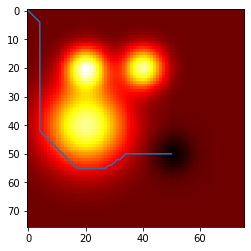

In [18]:
x_pos = []
y_pos = []
for x in path:
    x_pos.append(x[0])
    y_pos.append(x[1])
plt.plot(x_pos,y_pos)
plt.imshow(arr, cmap='hot', interpolation='nearest')
plt.show()

***????**

Now that we have tackled the problem of searching over a known field we need to address the more pressing challenge. Pathfinding over a unknown field. As described above, the strategy will be to update the map that we are pathfinding over, and then run a* on that. For simplicity we will simply say that the rover takes the next position identified by the a star pathfinding algorithm, and then rescans the environment and repeats the process.

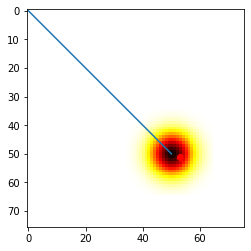

In [19]:
rover_init_postion = (0,0)
ball_location = (53,51) # The actual position of the ball. 
roverWorld = Initialise_tennis_ball_search()

plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
min_index = np.argwhere(roverWorld == np.min(roverWorld))
path_new = a_star(roverWorld,(0,0),(min_index[0][0],min_index[0][1]))
x_pos = []
y_pos = []
for x in path_new:
    x_pos.append(x[0])
    y_pos.append(x[1])
plt.plot(x_pos,y_pos)
plt.plot(ball_location[0],ball_location[1],"ro")
plt.show()

This the first step in the loop, the red dot on the graph represents the actual position of the tennis ball. To make things more challenging we will add 50 obstacles dotted throughout the region, generated randomly.

We then need to simulate the detection of these obstacles and targets. 

To do this we will use either random or user generated obstacle lists, when the rover is within a certain range of these obstacles the rover adds them to the map. A similar thing happens with the tennis ball, when it is within range the location of the tennis ball is set to be a place of high interest that the rover can navigate to. 

Randomly generating obstacles can be done but they wont necessarily get placed anywhere interesting, so the use can choose to drop them exactly in the path of the rover and then re run the notebook. This leads to more interesting behaviour. 

In [20]:
import random 
random.seed()
unknown_obstacles = [ ( random.randint(0, 70), random.randint(0, 70) ) for k in range(10) ]
unknown_obstacles = [(4,40),(55,30)]

unknown = set(unknown_obstacles)

roverLoc = rover_init_postion
def scan(known,obs,pos,tenLoc):
    new = known
    n_rows = len(known)
    n_cols = len(known[0])   
    for r_delta in [-2, -1, 0, 1, 2]:
        for c_delta in [-2,-1, 0, 1,2]:
            r = pos[0] + r_delta
            c = pos[1] + c_delta
            dist = r_delta**2 + c_delta**2
            # skip neighbors that would take us off the edge of the grid
            if r < 0 or r >= n_rows or c < 0 or c >= n_cols:
                continue
            if (r,c) in obs:
                new = applyGaussianToField(new,5.0/dist,c,r,1*dist)
                if (r,c) == tenLoc:
                    new = applyGaussianToField(new,-1.0/dist,c,r,1*dist)
            
            elif (r,c) == tenLoc:
                new = applyGaussianToField(new,-1.0/dist,c,r,1*dist)
            
            else:
                new[c,r] = 1
    return new
path = []

We will also add back the obstacles from the earlier sections to the rover map. We will tell the rover about these obstacles ahead of time, we can imagine these as simulating no-go zones that the rover will avoid based on satellite imagery analysis of the competition area.  

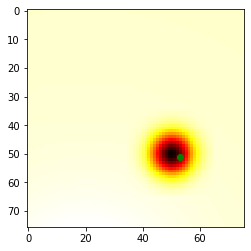

In [21]:
for i in range(len(obstacles)):
    roverWorld = applyGaussianToField(roverWorld,obstacles[i][3],obstacles[i][0],obstacles[i][1],obstacles[i][2])
plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro",color = "Green")
plt.show()

We can see the rovers initial understanding of the environment with the tennis ball position in green shown as well. The rover only has the rough estimate of the tennis ball position given from the rough guassian near it. It does not know the exact location of the tennis ball, only that it is most likely nearby. 

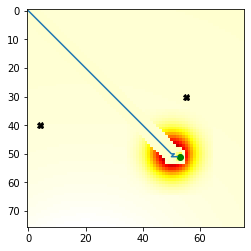

In [22]:
while roverLoc != ball_location:
    path.append(roverLoc)
    roverWorld = scan(roverWorld,unknown,roverLoc,ball_location)
    min_index = np.argwhere(roverWorld == np.min(roverWorld))[0]

    path_next = a_star(roverWorld,roverLoc,(min_index[1],min_index[0]))
    if path_next == []:
        roverWorld = roverWorld - 0.1
        continue

    roverLoc = path_next[1]

    
plt.imshow(roverWorld, cmap='hot', interpolation='nearest')
plt.plot(ball_location[0],ball_location[1],"ro",color = "Green")
x_pos = []
y_pos = []
for ob in unknown_obstacles:
    plt.plot(ob[0],ob[1],"X",color="black")
for x in path:
    x_pos.append(x[0])
    y_pos.append(x[1])
plt.plot(x_pos,y_pos)
plt.show()

The path the rover took to reach the final tennis ball is shown in blue and any obstacles added to the field are in black crosses and the rovers final knowledge of the environment. 

We can see that one of the major remaining issues is that the search path does not priorities driving over regions of interest on the way to any given target. This can be addressed by adjusting the heuristic of the a* search algorithm. But that is beyond the scope of this demonstration. 

The purpose was to demonstrate a decision making process for the rover to navigate an environment that it has only partial information about. It assumes a robust target recognition, obstacle detection and robot localisation system.  These will need to be built in order to work.